# DCGAN

In [ ]:
#Why DCGANs?
#DCGANs use convolutional layers to attempt to build GANs better suited for image data

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [59]:
from tensorflow.keras.datasets import mnist

In [60]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

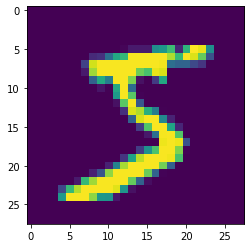

In [61]:
plt.imshow(X_train[0])

In [62]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

# Reshape and rescale images for DCGAN

In [63]:
X_train = X_train/255

In [64]:
X_train = X_train.reshape(-1, 28, 28, 1)*2. - 1.

In [65]:
X_train.min()

-1.0

In [66]:
X_train.max()

1.0

# Filtering out the Data for Faster Training on Smaller Dataset

In [67]:
zero_images = X_train[y_train==0]

In [68]:
zero_images.shape

(5923, 28, 28, 1)

In [69]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential

In [70]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100

In [71]:
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"))

In [72]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3), input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

In [73]:
GAN = Sequential([generator, discriminator])

In [74]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [75]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [76]:
GAN.layers

In [77]:
GAN.layers

In [78]:
GAN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [79]:
GAN.layers[0].summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
______________________________________________

In [80]:
GAN.layers[1].summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 0
Non-trainable params: 212,865
________________________________________________

# Setting up training batches

In [81]:
import tensorflow as tf

In [82]:
batch_size = 32

In [83]:
my_data = zero_images

In [84]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [85]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [86]:
epochs = 2

# Training Loop

In [87]:
generator, discriminator = GAN.layers

for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    
    for X_batch in dataset:
        i = i+1
        
        if i%20 == 0:
            print(f"\t Currently on batch number {i} of 185")
                                                         
        #Discriminator
        noise = tf.random.normal(shape=[batch_size,codings_size])
        gen_images = generator(noise)
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)],axis=0)
        y1 = tf.constant([[0.]]*batch_size + [[1.]]*batch_size)
        discriminator.trainable = True
        discriminator.train_on_batch(X_fake_vs_real,y1)
        
        #Train Generator                                                 
        noise = tf.random.normal(shape =[batch_size,codings_size])
        y2 = tf.constant([[1.0]]*batch_size)
        discriminator.trainable = False
        GAN.train_on_batch(noise,y2)

Currently on Epoch 1
	 Currently on batch number 20 of 185
	 Currently on batch number 40 of 185
	 Currently on batch number 60 of 185
	 Currently on batch number 80 of 185
	 Currently on batch number 100 of 185
	 Currently on batch number 120 of 185
	 Currently on batch number 140 of 185
	 Currently on batch number 160 of 185
	 Currently on batch number 180 of 185
Currently on Epoch 2
	 Currently on batch number 20 of 185
	 Currently on batch number 40 of 185
	 Currently on batch number 60 of 185
	 Currently on batch number 80 of 185
	 Currently on batch number 100 of 185
	 Currently on batch number 120 of 185
	 Currently on batch number 140 of 185
	 Currently on batch number 160 of 185
	 Currently on batch number 180 of 185


In [88]:
noise = tf.random.normal(shape=[10, codings_size])

In [89]:
noise.shape

TensorShape([10, 100])

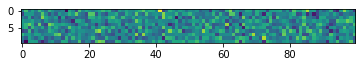

In [90]:
plt.imshow(noise)

In [91]:
images = generator(noise)

In [92]:
single_image = images[0]

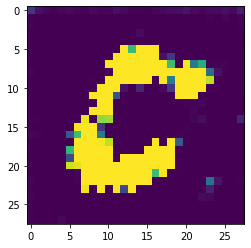

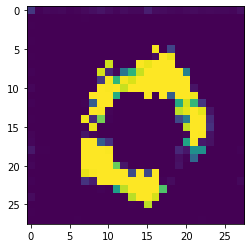

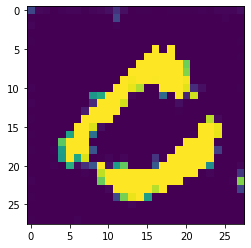

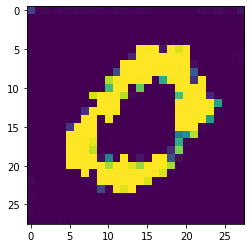

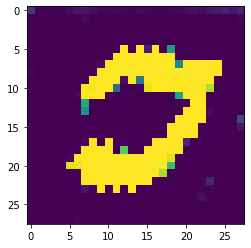

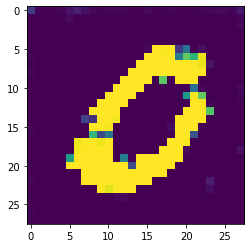

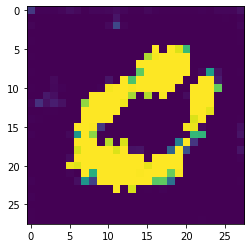

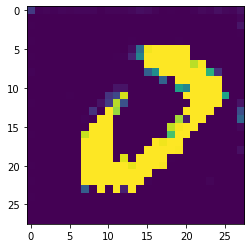

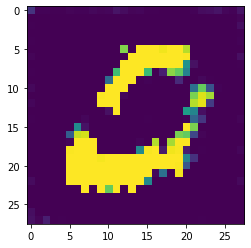

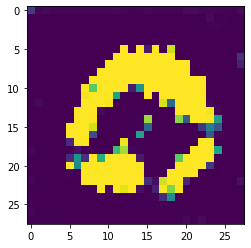

In [93]:
i = 0
for image in images:
    plt.imshow(image.numpy().reshape(28, 28))
    plt.imsave(fname='images/DCGAN/DCGANE2{}.png'.format(i+1),arr=image.numpy().reshape(28, 28))
    plt.show()
    i = i+1

In [94]:
len(images)

10